# Voluntary Carbon Credits by State 
### Jessica Mulcrone
### 2023-09-07

## Task:

The purpose of this project is to explore the voluntary carbon credit database and state emissions records on a state-by-state basis to identify geographic patterns and also to break down carbon credit data to a project and developer level to see whether project type and project or developer dominance patterns differ between states that produce larger and small amounts of voluntary carbon offsets. Findings could inform plans to encourage more voluntary carbon credit creation in lighter producing states. The final section focuses on the Sustainable Agriculuture project type out of personal curiosity as this is the type of project I have the most familiarity with. 

## Overview:

The Voluntary Registry Offsets database was developed by the Berkeley Carbon Trading Project and contains carbon credits information from the four major carbon offset registries: American Carbon Registry, Climate Action Reserve, Gold Standard, and Verra. These four registries generate almost all of the world's voluntary offset credits. Voluntary credits are purchased by companies that want to offset their carbon emissions and while there is debate around the effectiveness of carbon credits to combat climate change and concerns over 'greenwashing,' the voluntary carbon market is growing very quickly and passed the 2 billion value in 2021. There is an abundance of analysis on carbon credit trends as many stakeholders are invested in the direction of the market. This report was created to familarize myself with the make-up of the carbon credit market first hand and to answer specific questions I'm interested in about what project type spread looks like in states and across the country.  


## Data: 

The Voluntary Registry Offsets database is publicly available for download at berkeley.edu and State Energy Related Carbon Emissions by Year data is publicly available at the U.S. Energy Information Administration. 

Ivy S. So, Barbara K. Haya, Micah Elias. (2023, May). Voluntary Registry Offsets Database v8, Berkeley Carbon Trading Project, University of California, Berkeley. Retrieved from: https://gspp.berkeley.edu/faculty-and-impact/centers/cepp/projects/berkeley-carbon-trading-project/offsets-database

U.S. Energy Information Administration. (2023). State Energy Related Carbon Emissions by Year [database].

## Key Questions: 

### Total Carbon Credits and Historic & Recent Emission Changes

1. Which states produce the most and least voluntary carbon credits? Is there a regional pattern?
2. Which states had the largest and smallest carbon emissions in 2021? Is there a geographic pattern?
3. Which states have the largest and smallest historic emissions changes? Is there a regional pattern?
4. Which states have the largest and smallest recent emisisons changes? Is there a regional pattern? Does this differ from regional patterns for historic emissions changes?
5. Do states with large historic/ recent carbon emission create voluntary offset credits more often than states with low historic/ recent emissions? 
6. Do states that create voluntary credits most often have larger emissions changes than other states?

### Project Type 

1. Which states have the largest percentage of credits attributed to one project type? Is there a regional pattern? 
2. Does most frequent project type vary by region?
3. Are states that heavily create credits more likely to have a dominant project type?
4. Are states with large historic or recent change in emissions more likely to have a dominant project type? What about states with low change in emissions? What about high or low total emissions? 
5. Are some project types more likely to dominate a state's credits than others?
6. Which project types are most likely to be the largest contributors by state?
7. Do any project types dominate carbon credits country-wide?

### Project Developer

1. Which states have the largest percentage of credits attributed to one project developer? Is there a regional pattern? How does this compare to project type dominance?
2. Are states that heavily create credits more likely to do so with a specific project developer? What about lightly create credits?
3. Are there any developers that are often the largest in multiple states?
4. Do any developers dominate carbon credits country-wide?*

### Sustainable Agriculture 

1. What percentage of credits do Sustainable Agriculture projects make up?
2. Which states create the most credits from Sustainable Agriculture? 
3. Which project developers are most involved with Sustainable Agriculture projects?

## Data Cleaning and Manipulation: 

Data from the voluntary carbon credit database was grouped by state and total carbon credits per state were summed. This data was
further grouped by project type, summed, and divided by total credits to find project type percentages. The same process was followed
for developers. State names were altered in the voluntary carbon credit database to match emissions and geographic data as a key. 
Entries for territories that were not present in all data sets were dropped. Project types with zero credits were dropped to reduce 
crowding on graphics.

###  Loading Libraries and Data

In [2]:
#Load libraries 
%matplotlib inline
import os
import fiona
from matplotlib import pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely
import shapely.geometry
import numpy as np
import json
import folium
import mplleaflet
import cartopy.crs as ccrs # import projection
import cartopy.feature as cf # import features
import seaborn as sns


#Load Data 
geojson = '/home/jovyan/shared_data/data/geog407/exam1/us-states.json'
voluntary_offset_file = 'voluntary_offset_4.csv'
emissions_file = 'emissions_2.csv'

#Read thb CSV file into a pandas DataFrame
voluntary_offset = pd.read_csv(voluntary_offset_file)
emissions = pd.read_csv(emissions_file)

###  Total Carbon Credits and Historic & Recent Emission Changes

In [3]:
# Group voluntary carbon credits database by state and sum
total_credits_state=voluntary_offset.groupby(['State'])['Total Credits Issued'].sum().reset_index(name ='Total_Credits')

#Change state names to match geographic data 
total_credits_state['State'] = total_credits_state['State'].astype(str)
total_credits_state['State']= total_credits_state.State.str.lower()
total_credits_state.State = total_credits_state.State.str.title()

# Merge total credits table and emissions table
merged_table=pd.merge(total_credits_state, emissions, on='State', how='left')

# Drop territories from merged table that do not match geo data
merged_table=merged_table.drop([5,8,10,36])

# Change emissions 2021 column to float type and drop row for total for choropleth map
emissions=emissions.drop([51])
emissions['2021'] = emissions['2021'].astype(float)

###  Project Type 

In [4]:
# By state

# Create table that groups carbon credit table by state and type and returns total credits issued in a new column, then add a column 
# that gives which total project credit is the max, and filter for that max
project_credits=voluntary_offset.groupby(['State',' Type'])['Total Credits Issued'].sum().reset_index(name ='Total_Project_Credits')
project_credits['project_credits_max'] = project_credits.groupby(['State'])['Total_Project_Credits'].transform(max)
project_credits_2= project_credits.loc[project_credits['Total_Project_Credits'] == project_credits['project_credits_max']]

# Create a table that groups by state and sums the total credits from all projects and merge tables so max project credits and sum of 
# credits from all projects are in the same table, then add a column for percent credits from the largest project type
project_credits_total= voluntary_offset.groupby(['State'])['Total Credits Issued'].sum().reset_index(name ='Total_Credits_Sum')
merged_credits_table=pd.merge(project_credits_2, project_credits_total, on='State', how='left')
merged_credits_table['percent_credits_from_max'] = merged_credits_table['project_credits_max']/merged_credits_table['Total_Credits_Sum']

# Convert state names to match geo data
merged_credits_table['State'] = merged_credits_table['State'].astype(str)
merged_credits_table['State']= merged_credits_table.State.str.lower()
merged_credits_table.State = merged_credits_table.State.str.title()

# Merge project table with emissions data and drop territories that don't match both geo and emissions data
merged_credits_table_2 = pd.merge(merged_credits_table, emissions, on='State', how='left')
merged_credits_table_2=merged_credits_table_2.drop([5,8,10,13,36])

## Country-wide

# Group voluntary credit table by project type and total credits issued. 
total_credits_type=voluntary_offset.groupby([' Type'])['Total Credits Issued'].sum().reset_index(name ='Total_Credits')

# Drop rows where total credits is zero and line where type is zero (*using Total_Credits column to do so because Type column has a space)
total_credits_type = total_credits_type.drop(total_credits_type[total_credits_type.Total_Credits == 0.0].index)
total_credits_type = total_credits_type.drop(total_credits_type[total_credits_type.Total_Credits == 2000].index)

# Add a column for percent of total credits each project type makes up
total_credits_type['Percent'] = total_credits_type['Total_Credits']/total_credits_type['Total_Credits'].sum()

###  Project Developer 

In [5]:
# Create table that groups by state and project develper and returns total credits issued in a new column, then add a column
# that gives which developer is has the max credits, and filter for that max developer
developer_credits= voluntary_offset.groupby(['State','Project Developer'])['Total Credits Issued'].sum().reset_index(name ='Total_Developer_Credits')
developer_credits['developer_credits_max'] = developer_credits.groupby(['State'])['Total_Developer_Credits'].transform(max)
developer_credits_2= developer_credits.loc[developer_credits['Total_Developer_Credits'] == developer_credits['developer_credits_max']]

# Create a table that groups by state and sums the total credits from all projects (identical to project credits total from earlier) and 
# merge tables so that max developer and sum of credits from all developers are in the same table, then add a column for percent credits
# from the max developer
developer_credits_total= voluntary_offset.groupby(['State'])['Total Credits Issued'].sum().reset_index(name ='Total_Credits_Sum')
merged_credits_table_3=pd.merge(developer_credits_2,developer_credits_total,on='State', how='left')
merged_credits_table_3['developer_percent_credits_from_max'] = merged_credits_table_3['developer_credits_max']/merged_credits_table_3['Total_Credits_Sum']

# Change state names to match geo data
merged_credits_table_3['State'] = merged_credits_table_3['State'].astype(str)
merged_credits_table_3['State']= merged_credits_table_3.State.str.lower()
merged_credits_table_3.State = merged_credits_table_3.State.str.title()

# Merge developer table with emissions data and drop territories that don't match both geo and emissions data
merged_credits_table_4= pd.merge(merged_credits_table_3,emissions,on='State', how='left')
merged_credits_table_4=merged_credits_table_4.drop([5,8,10,13,36])

## Country-wide

# Group voluntary credit table by developer and total credits issued. 
total_credits_dev=voluntary_offset.groupby(['Project Developer'])['Total Credits Issued'].sum().reset_index(name ='Total_Credits')

# Drop rows where total credits is zero and line where type is zero (*using Total_Credits column to do so because Type column has a space)
total_credits_dev = total_credits_dev.drop(total_credits_dev[total_credits_dev.Total_Credits == 0.0].index)

# Add a column for percent of total credits each project type makes up
total_credits_dev['Percent'] = total_credits_dev['Total_Credits']/total_credits_dev['Total_Credits'].sum()

# Change percent to float and select for developers producing 2% of carbon credits or more contry-wide
total_credits_dev['Percent'] = total_credits_dev['Percent'].astype(float)
total_credits_dev_largest = total_credits_dev[total_credits_dev.Percent > .01]

###  Sustainable Agriculture

In [6]:
# By state

# Create table that groups by state and type and returns total credits issued in a new column
project_credits_s_a=voluntary_offset.groupby(['State',' Type'])['Total Credits Issued'].sum().reset_index(name ='Total_Project_Credits')

# Filter for project type of sustainable agriculture
project_credits_s_a_2 = project_credits_s_a.loc[(project_credits_s_a[" Type"] == "Sustainable Agriculture")]

# Merge sustainable agriculture table with projects total credits table so sustainable agriculture
# and sum of credits from all projects are in the same table
project_credits_s_a_3 = pd.merge(project_credits_s_a_2, project_credits_total, on='State', how='left')

# Add a column of percent credits from sustainable agriculture
project_credits_s_a_3['percent_SA'] = project_credits_s_a_3['Total_Project_Credits']/project_credits_s_a_3['Total_Credits_Sum']

# Country-wide

# Create a table of all the stainable ariculture project developers by grouping by project name and type and returning sum of credits
# issued, then filtering for Type sustainable agriculture
credits_type_dev = voluntary_offset.groupby(['Project Name', ' Type', 'Project Developer'])['Total Credits Issued'].sum().reset_index(name ='Total_Project_Credits')
credits_s_a_dev = credits_type_dev.loc[credits_type_dev[' Type'] == 'Sustainable Agriculture']

## Analysis, Key Findings, and Visualizations: 

### Total Carbon Credits and Historic & Recent Emission Changes

###  Map of Total Credits by State

In [ ]:
# Plot basemap
m =folium.Map(location=[48, -102], zoom_start=3)

# Plot choropleth map
folium.Choropleth(
    geo_data=geojson,
    name="choropleth",
    data=total_credits_state,
    columns=["State", "Total_Credits"],
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Total_credits",
).add_to(m)

# Add layer control
folium.LayerControl().add_to(m)
m

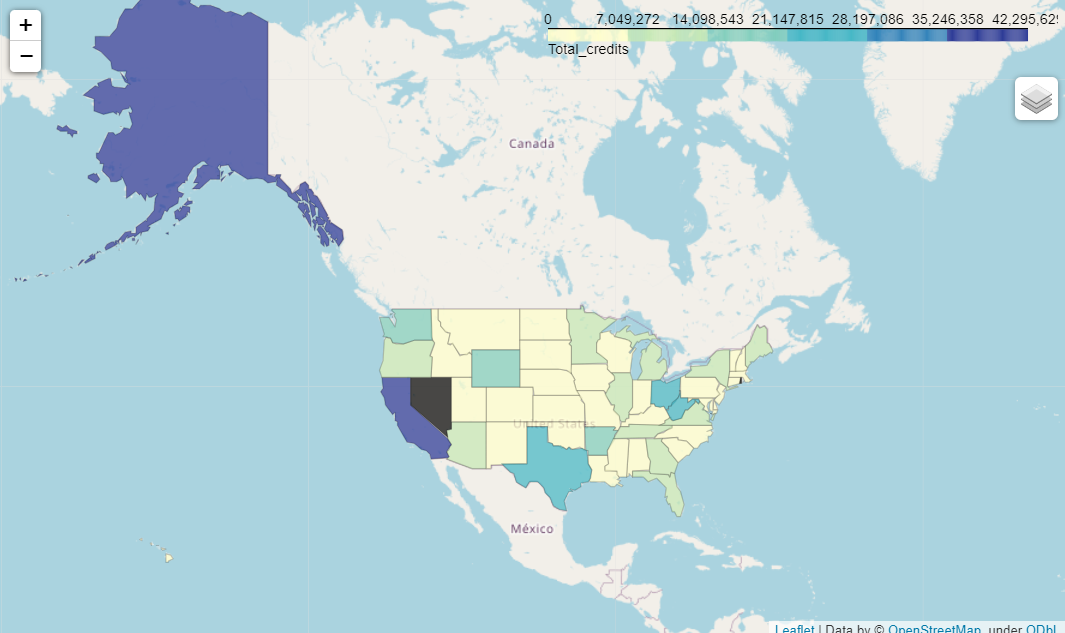

*Which states create the most and least voluntary carbon credits? Is there a regional pattern?*

**California and Alaska have the highest number of voluntary carbon credits, followed by Texas, Ohio, and West Virginia, then Washington, Wyoming, and Arkansas. The Great Plains region had the least credits and the west coast had the most, though high and low credit states were fairly dispersed across the country.** California and Alaska are both large states with vast wilderness which may provide opportunity to undertake higher scale carbon credit projects than other states. 

###  Map of Total Emissions by State 2021

In [ ]:
# Plot basemap
m =folium.Map(location=[48, -102], zoom_start=3)

# Plot choropleth map
folium.Choropleth(
    geo_data=geojson,
    name="choropleth",
    data=emissions,
    columns=["State", "2021"],
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Total Emissions 2021",
).add_to(m)

# Add Layer control
folium.LayerControl().add_to(m)
m

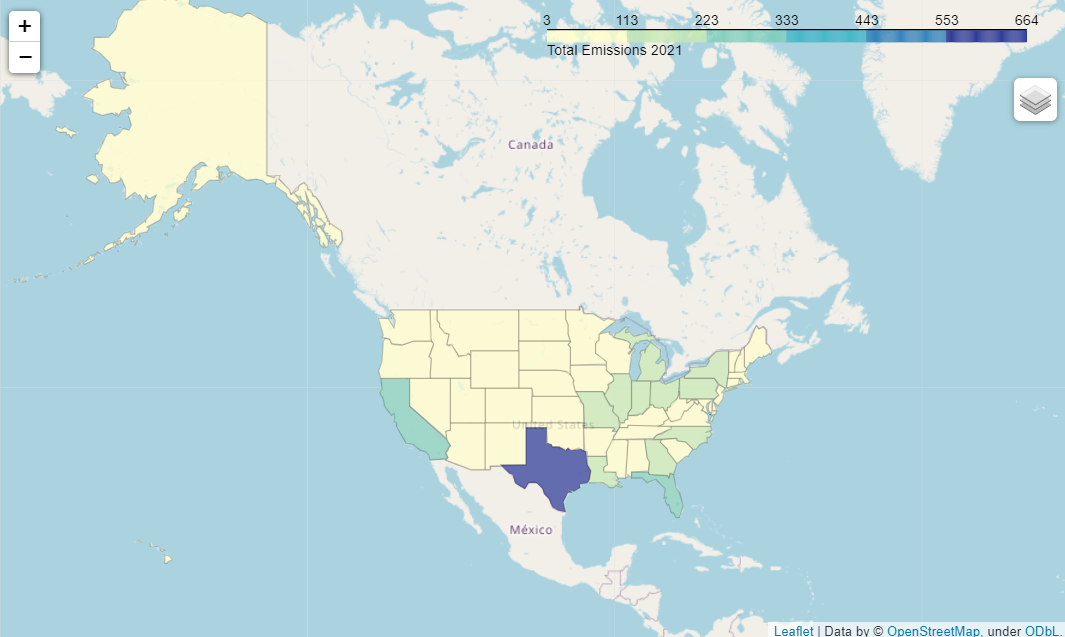

*Which states had the largest and smallest carbon emissions in 2021? Is there a geographic pattern?*

**Texas has the largest carbon emissions in 2021, followed by California and Florida, and then the Rust Belt.** These could be due to a combination of industry and population. 

###  Map of Emissions Changes 1970-2021

In [ ]:
# Plot basemap
m =folium.Map(location=[48, -102], zoom_start=3)

# Plot choropleth map
folium.Choropleth(
    geo_data=geojson,
    name="choropleth",
    data=emissions,
    columns=["State", "Percent 1970_2021"],
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Percent Change in Emissions 1970 to 2021",
).add_to(m)

# Add Layer control
folium.LayerControl().add_to(m)
m

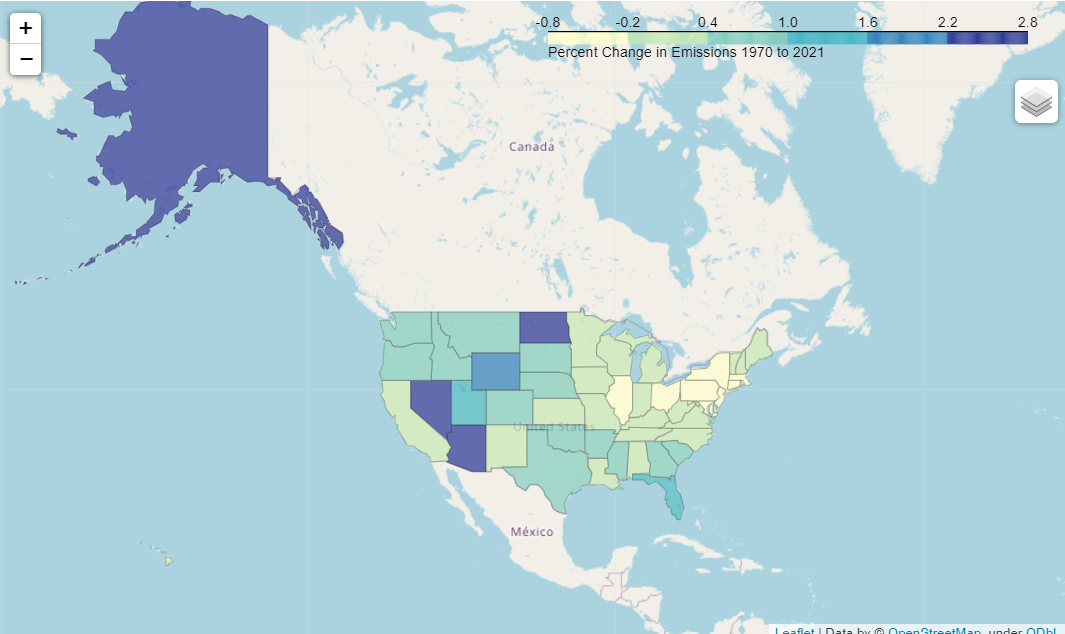

*Which states have the largest and smallest historic emissions changes? Is there a regional pattern?* 

**Alaska, North Dakota, Nevada, and Arizona had the largest increase in emissions from 1970 to 2021 while Illinois and a cluster of states in Midwest/ Northeast had the smallest. Historic emissions changes are larger in the west and the south compared to the northeast.** This pattern could be due to population shifts away from the states with small emissions changes towards states with larger emissions changes as the the Northwest and coasts became more popular for residency.

###  Map of Emissions Change 2019-2021 by State 

In [ ]:
# Plot basemap
m =folium.Map(location=[48, -102], zoom_start=3)

# Plot choropleth map
folium.Choropleth(
    geo_data=geojson,
    name="choropleth",
    data=emissions,
    columns=["State", "Percent 2019_2021"],
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Percent Change in Emissions 2019 to 2021",
).add_to(m)

# Add Layer control
folium.LayerControl().add_to(m)
m

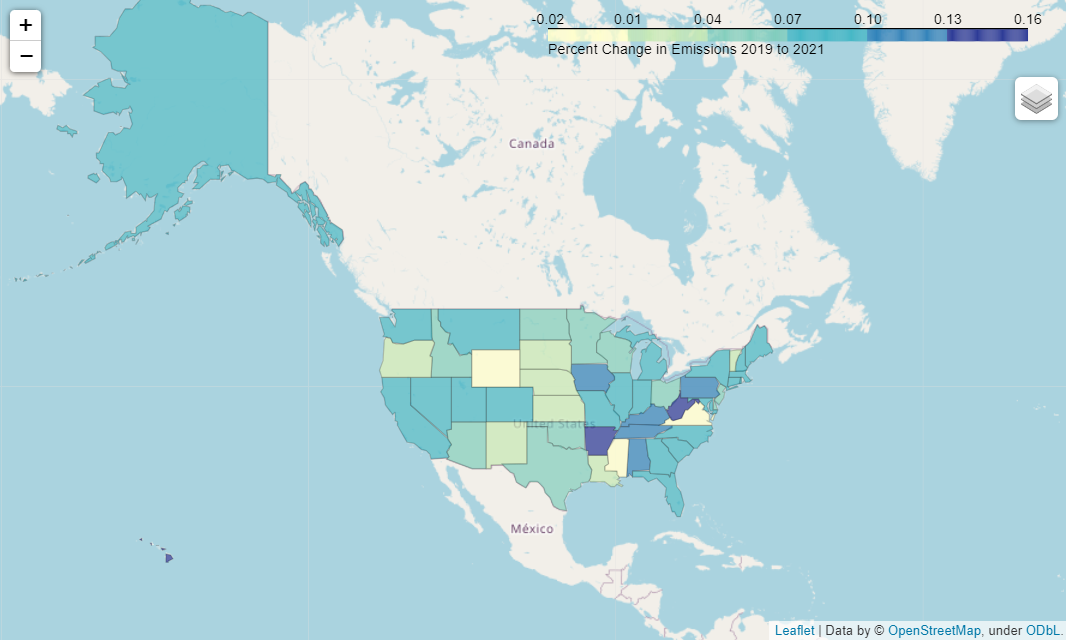

*Which states have the largest and smallest recent emissions changes? Is there a regional pattern? Does this differ from regional patterns for historic emissions changes?* 

**Arkansas and West Virginia had the largest increase in emissions from 2019 to 2021 followed by Iowa, Pennsylvania, Alabama, Tennessee, and Kentucky. Virgina, Wyoming, and Mississippi had the smallest increases. The largest recent emission changes are clusterd in the Southeast.** Some of the emissions increases in the southeast may be due to population increases. Other possible explanations include increases in energy generation (coal, natural gas) and policy changes. **The recent emissions change geographical pattern differs from the historic emissions change geographical pattern; historic changes were concentrated in the northwest while recent changes are concentrated in the southeast.**

###  Scatterplot of Total Offset Credits vs. Emissions Changes 1970-2021 & 2019-2021, & Total Emissions 2021

In [ ]:
# Create plot 1970-2021
ax1 = merged_table.plot(kind='scatter', x='Total_Credits', y='Percent 1970_2021')
plt.xlabel('Total Credits')
plt.ylabel('Percent 1970-2021')
plt.title('Total Credits vs. Change in Emissions 1970-2021')

# Fit linear model & plot trend line
data = merged_table[['Total_Credits', 'Percent 1970_2021']]
x = data['Total_Credits']
y = data['Percent 1970_2021']
z = np.polyfit(x, y, 1) 
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

# Find R2 value
from sklearn.metrics import r2_score

coefficient_of_determination = r2_score(y, p(x))
print('R2 =', coefficient_of_determination)
plt.savefig('bill.jpg')

# Create plot 2019-2021
ax2 = merged_table.plot(kind='scatter', x='Total_Credits', y='Percent 2019_2021')
plt.xlabel('Total Credits')
plt.ylabel('Percent 2019-2021')
plt.title('Total Credits vs. Change in Emissions 2019-2021')

# Fit linear model & plot trend line
data = merged_table[['Total_Credits', 'Percent 2019_2021']]
x = data['Total_Credits']
y = data['Percent 2019_2021']
z = np.polyfit(x, y, 1) 
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

#find R2 value
from sklearn.metrics import r2_score

coefficient_of_determination = r2_score(y, p(x))
print('R2 =', coefficient_of_determination)

# Change type to float for values of emissions in 2021
merged_table['2021'] = merged_table['2021'].astype(float)

# Create plot for total emissions 2021
ax3 = merged_table.plot(kind='scatter', x='Total_Credits', y='2021')
plt.xlabel('Total Credits')
plt.ylabel('Total Emissions 2021')
plt.title('Total Credits vs. Total Emissions 2021')

# Fit linear model & plot trend line
data = merged_table[['Total_Credits', '2021']]
x = data['Total_Credits']
y = data['2021']
z = np.polyfit(x, y, 1) 
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

merged_table['2021'].dtypes
merged_table['Total_Credits'].dtypes

# Find R2 value
from sklearn.metrics import r2_score

coefficient_of_determination = r2_score(y, p(x))
print('R2 =', coefficient_of_determination)
;

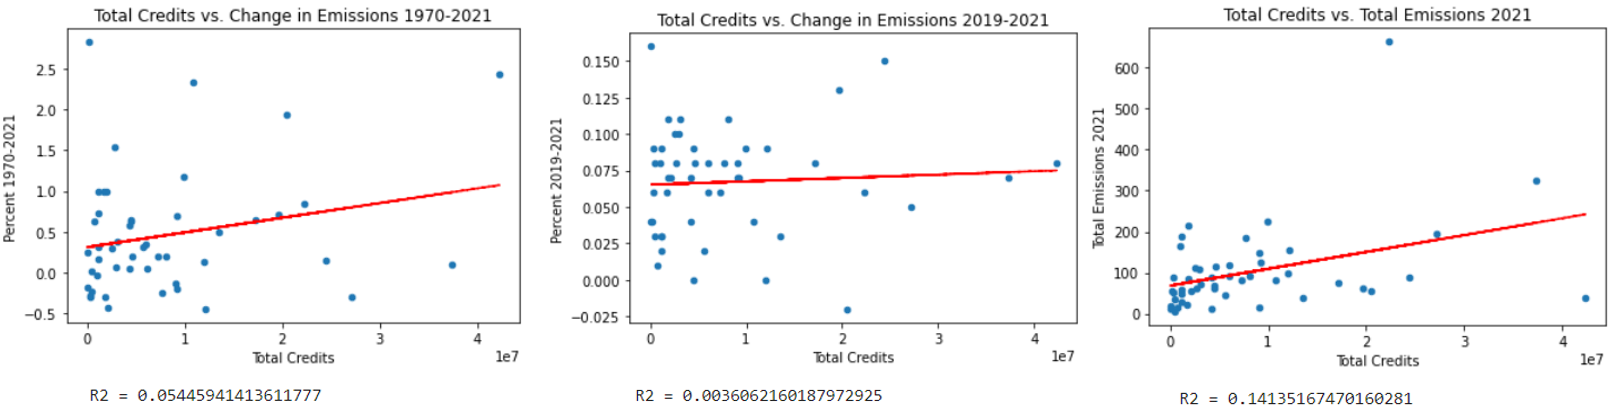

*Do states with large historic/ recent carbon emission create voluntary offset credits more often than states with low historic/ recent emissions?*

Total credits correlated weakly and positively (r2=0.054) with emissions change from 1970 to 2021 (left), extremely weakly (r2=0.003) with emissions change from 2019 to 2021 (middle).

*Do states that create voluntary credits most often have larger emissions changes than other states?*

Total credits correlated medium-weakly and positively (r2=0.141) with total emissions in 2021 (right). 

**States with larger emissions and emissions changes are somewhat more likely to create carbon credits.** The pattern could be a product of larger size and/ or populations leading to both more credit creation and more emissions. Historic emissions and total emissions correlating more strongly with total credits would seem to support the population driver hypothesis and this question could be further explored using population data. 

### Project Type 

### Map of % Credits from Largest Project Type

In [ ]:
# Plot basemap
m =folium.Map(location=[48, -102], zoom_start=3)

# Plot choropleth map
folium.Choropleth(
    geo_data=geojson,
    name="choropleth",
    data=merged_credits_table_2,
    columns=["State", "percent_credits_from_max"],
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="% Credits from Largest Project Type",
).add_to(m)

# Add Layer control
folium.LayerControl().add_to(m)
m

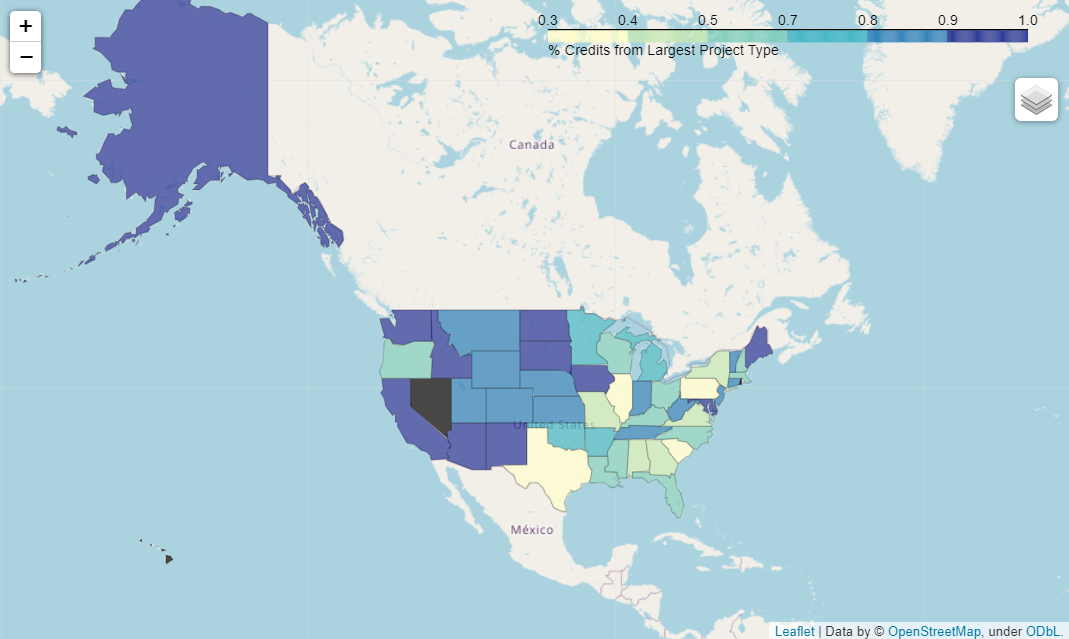

*Which states have the largest percentage of credits attributed to one project type? Is there a regional pattern?*

**Alaska, Washington, Idaho, California, Arizona, New Mexico, North and South Dakota, Iowa, Maryland, Rhode Island, and Maine get nearly all of their credits from one project type, whereas Illinois, Texas, Pennsylvania, and South Carolina get less than 40% of their credits from largest project type. In general, the western states seem more likely to have a large percentage of credits from one project type than eastern states.** The larger percentage of credits from one project type in the west might be due to vast amounts of wilderness lending itself to one specific project type. 

### Map of Largest Project Type by State

In [ ]:
# Create new table with renamed State column to match shapefile state column NAME
merged_credits_table_5 = merged_credits_table_2.rename(columns = {'State':'NAME'})

# Read shapefile and database file
shape= gpd.read_file('tl_2017_us_state.shp')
file = gpd.read_file('tl_2017_us_state.dbf')

# Merge table, shapefile, and database
file_and_type= pd.merge(file, merged_credits_table_5, on=['NAME'], how='left')

# Plot
fig, ax = plt.subplots(1, figsize=(100,50))
file_and_type.plot(column=' Type', categorical=True, cmap='Spectral', linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.3, 1.05),'fontsize':20,'frameon':True}, ax=ax)
ax.axis('off')
ax.set_title('Largest Project Type by State',fontsize=45)
plt.tight_layout()
plt.savefig('type_map.png',dpi=300) 

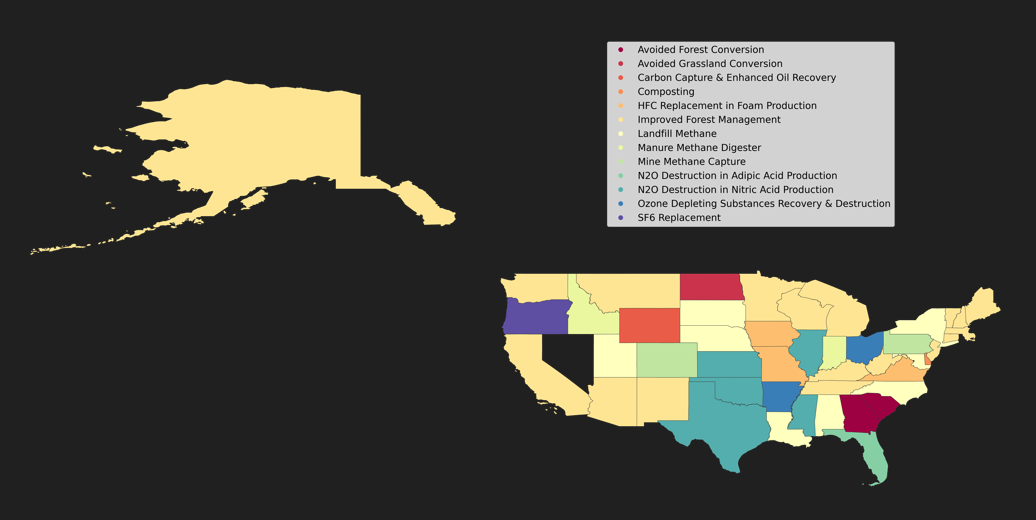

*Does most frequent project type vary by region?*

**Western states and larger states with wildnerness land did tend have Improved Forest Management or Avoided Grassland and Forest Conversion as thier largest project type, while eastern and smaller states tended to have more production-related largest project types, though the pattern is not decisive.** This pattern supports the possibility that states in the west tend to have more dominant project types because of their vase amounts of land. 

### Scatterplot of % Credits from Largest Project vs. Total Credits, Emissions Changes 1970-2021 & 2019-2021, & Total Emissions 2021

In [ ]:
# Create plot % credits from largest project vs total credits per state color coded by project type
plot_1= sns.scatterplot(x="Total_Credits_Sum", y="percent_credits_from_max",
              hue=" Type",
              data=merged_credits_table_2);
plot_1.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.xlabel('Total Credits Sum')
plt.ylabel('% Credits from Largest Project Type Cont.')
plt.title('Total Credits vs % Credits from Largest Project Type')

# Fit linear model & plot trend line
data = merged_credits_table_2[['Total_Credits_Sum', 'percent_credits_from_max']]
x = data['Total_Credits_Sum']
y = data['percent_credits_from_max']
z = np.polyfit(x, y, 1) 
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

# Find R2 value
coefficient_of_determination = r2_score(y, p(x))
print('R2 =', coefficient_of_determination)

# Create plot % credits from largest project vs emission change 1970-2021 color coded by project type
plot_2= sns.scatterplot(x="Percent 1970_2021", y="percent_credits_from_max",
              hue=" Type",
              data=merged_credits_table_2);
plot_2.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.xlabel('% Change in Emission 1970-2021')
plt.ylabel('% Credits from Largest Project Type Cont')
plt.title('% Change in Emission 1970-2021 vs % Credits from Largest Project Type')

# Fit linear model & plot trend line
data = merged_credits_table_2[['Percent 1970_2021', 'percent_credits_from_max']]
x = data['Percent 1970_2021']
y = data['percent_credits_from_max']
z = np.polyfit(x, y, 1) 
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

# Find R2 value
coefficient_of_determination = r2_score(y, p(x))
print('R2 =', coefficient_of_determination)

# Create plot % credits from largest project vs emission change 2019-2021 color coded by project type
plot_3= sns.scatterplot(x="Percent 2019_2021", y="percent_credits_from_max",
              hue=" Type",
              data=merged_credits_table_2);
plot_3.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.xlabel('% Change in Emission 2019-2021')
plt.ylabel('% Credits from Largest Project Type Cont.')
plt.title('% Change in Emission 2019-2021 vs % Credits from Largest Project Type')

# Fit linear model & plot trend line
data = merged_credits_table_2[['Percent 2019_2021', 'percent_credits_from_max']]
x = data['Percent 2019_2021']
y = data['percent_credits_from_max']
z = np.polyfit(x, y, 1) 
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

# Find R2 value
coefficient_of_determination = r2_score(y, p(x))
print('R2 =', coefficient_of_determination)

# Create plot % credits from largest project vs total emissions 2021 color coded by project type
plot_4= sns.scatterplot(x="2021", y="percent_credits_from_max",
              hue=" Type",
              data=merged_credits_table_2);
plot_4.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.xlabel('Total Emissions 2021')
plt.ylabel('% Credits from Largest Project Type Cont.')
plt.title('Total Emissions 2021 vs % Credits from Largest Project Type')

# Fit linear model, plot trend line
data = merged_credits_table_2[['2021', 'percent_credits_from_max']]
x = data['2021']
y = data['percent_credits_from_max']
z = np.polyfit(x, y, 1) 
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

# Find R2 value
coefficient_of_determination = r2_score(y, p(x))
print('R2 =', coefficient_of_determination)

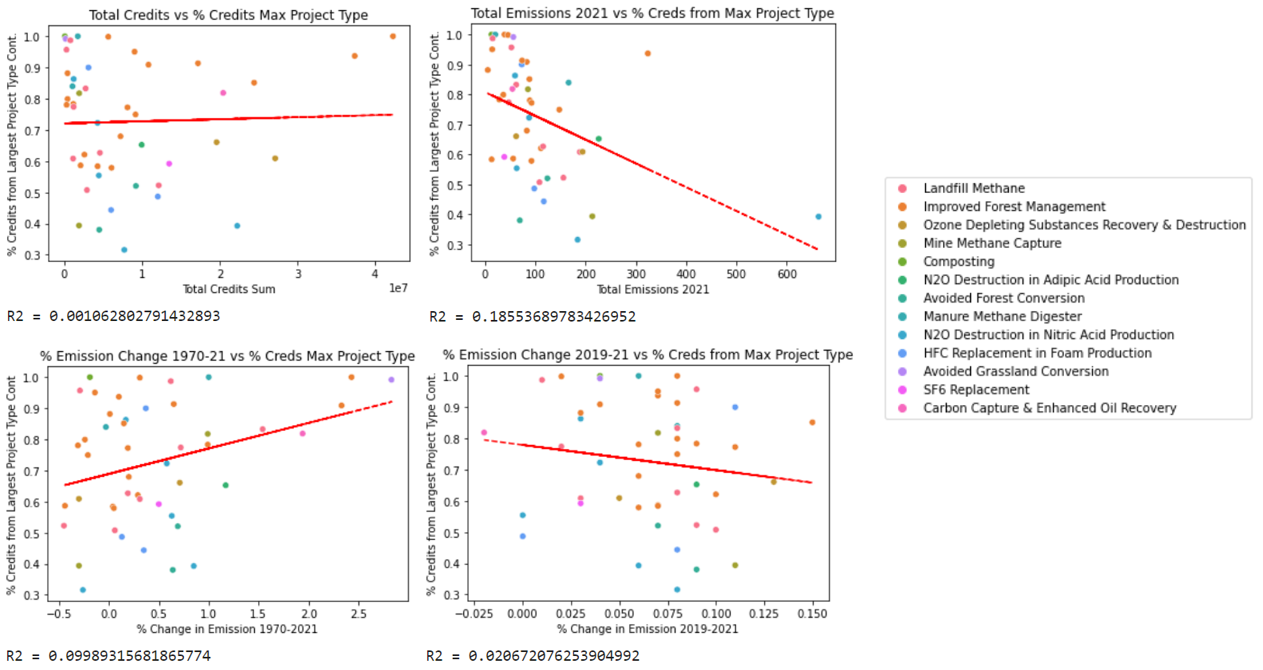

*Are states that heavily create credits more likely to have a dominant project type?*

Percent credits from the largest project type correlated extremely weakly and positively (r2=0.001) with total credits created (upper left).

**Increased carbon credits does not predict percent credits from dominant project type. This suggests a low number of projects does not drive project type domination.** 

*Are states with large historic or recent change in emissions more likely to have a dominant project type? What about states with low change in emissions? What about high or low total emissions?* 

Percent credits from the largest project type correlated more strongly and positively (r2=0.100) with percent change in emissions from 1970 to 2021 (lower left), weakly negatively (r2=0.021) with percent change in emissions from 2019 to 2021 (lower right), and moderately negatively (r2=0.186) with total emissions (upper right) though that trend is strongly driven by the largest emission state.

**Large historic emissions changes weakly predict a higher percentage of credits from dominant project types, while large recent emissions changes weakly predict a lower percentage. Large total emission predict a lower percentage of credits from the dominant project type.** Historic emissions change's positive correlation with project dominance might because both are more likely to occur in western states with large wildnerness-based projects, and the recent change's negative correlation with project dominance might be because recent emisssions changes are more common in eastern states with smaller industry-based projects. The negative correlation between total emissions and project type dominance is likely from high emissions in the corn belt where project types tend to be varied and Texas having the most emissions by far and high project type diversity. 

### Bar graph of % Credits from Largest Project Type by State

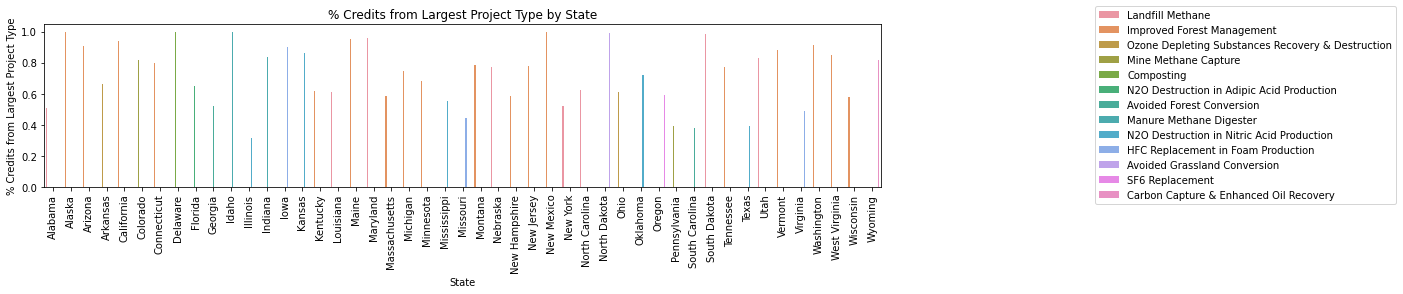

In [14]:
plot_bar= sns.barplot(x="State", y="percent_credits_from_max", data=merged_credits_table_2, hue=" Type",)
plot_bar.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.gcf().set_size_inches(15,3)
plt.xticks(rotation = 90)
plt.xlabel('State')
plt.ylabel('% Credits from Largest Project Type')
plt.title('% Credits from Largest Project Type by State');

*Are some project types more likely to dominate a state's credits than others?* 

**Lanfill Methane, Improved Forest Management, Ozone Depleting Substant Recovery & Deconstruction, and Mine Methane Capture were most likely to dominate a states credits, though overall there was a decent dispersal of project types dominating states' credits.**

### Pie Chart States' Largest Project Type

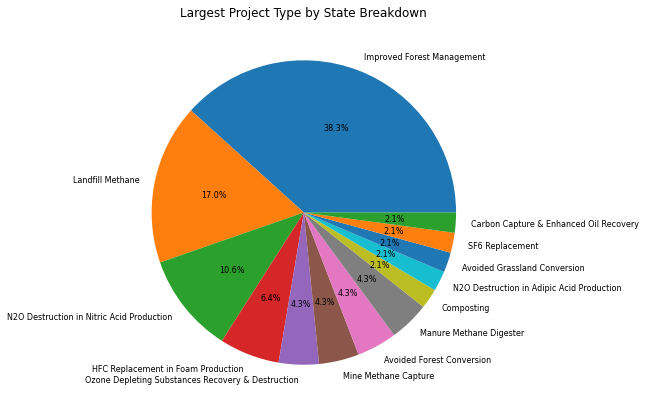

In [15]:
merged_credits_table_2[' Type'].value_counts().plot.pie( title = 'Largest Project Type by State Breakdown', 
                                                        fontsize = 8, autopct ='%1.1f%%', ylabel='', figsize=(7, 7));

*Which project types are most likely to be the largest contributors by state?*

**Improved Forest Management was by far the most common at 38.3% followed by Landfill Methane at 17% and N2O Destruction in Nitric Acid Production at 10.6%.** Improved Forest Management and Landfill Methane may take less resources to accomplish than other project types or yield high credits for being impactful. It is also possible that these two project types lend themselves to large-scale projects. 

### Bar Graph of Project Type % Country-Wide

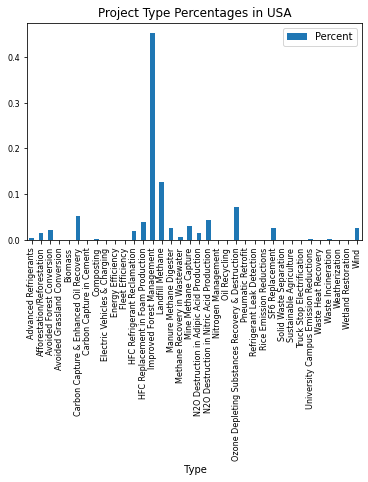

In [16]:
total_credits_type.plot.bar( x = ' Type', y = 'Percent', title = 'Project Type Percentages in USA', fontsize= 8);

*Do any project types dominate carbon credits country-wide?*

**Improved Forest Management projects account for over 40% of the voluntary carbon credits nation-wide and accounts for the most carbon credits country-wide by a huge margin. Landfill Methane accounts for close to 15% of carbon credits, Ozone Depleting Substances Recovery & Destruction accounts for almost 10% of credits, and Carbon Capture & Enhanced Oil Recovery and N20 Destruction in Nitric Acid Production each account for about 5%.** 

## Project Developer 

##  Map of Emissions fro Largest Developer by State

In [ ]:
# Plot basemap
m =folium.Map(location=[48, -102], zoom_start=3)

# Plot choropleth map
folium.Choropleth(
    geo_data=geojson,
    name="choropleth",
    data=merged_credits_table_4,
    columns=["State", "developer_percent_credits_from_max"],
    key_on="feature.properties.name",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="% Credits from Largest Developer",
).add_to(m)

# Add Layer control
folium.LayerControl().add_to(m)
m

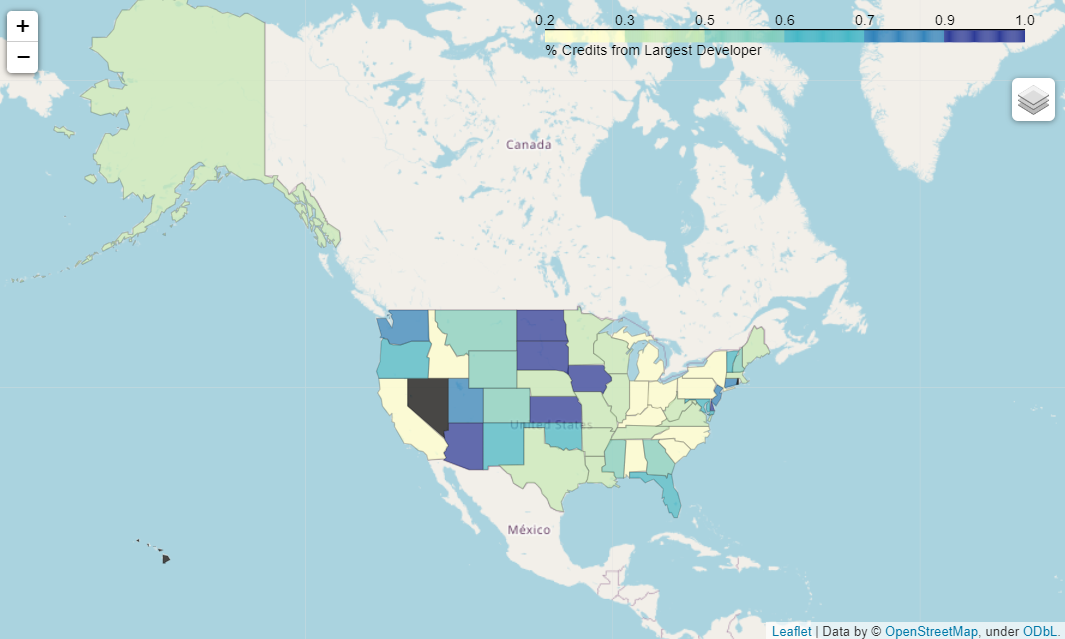

*Which states have the largest percentage of credits attributed to one project developer? Is there a regional pattern? How does this compare to project type dominance?*

**Arizona, Iowa, Kansas, and North and South Dakota get nearly all of their credits from a single developer. In general, western states are more likely than eastern states to get most of their credits from one developer, similar to the pattern of western states being more likely to get most of their credits from a single project type than eastern states.** However, this pattern is likely due to states with fewer credits being more likely to be dominated by a single or fewer developers, unlike the pattern in project type.** 

###  Scatterplot of % Credits from Max Producer vs. Total Credits, Emissions Change 1970-21 & 2019-21, and Total Emissions 2021

In [ ]:
# Create a scatterplot of percent credits from max developer vs total credits 
merged_credits_table_4.plot(kind='scatter', x='Total_Credits_Sum', y='developer_percent_credits_from_max')
plt.xlabel('Total Credits')
plt.ylabel('% Credits from Max Developer')
plt.title('Total Credits vs. % Credits from Max Developer')

# Fit linear model, plot trend line
data = merged_credits_table_4[['Total_Credits_Sum', 'developer_percent_credits_from_max']]
x = data['Total_Credits_Sum']
y = data['developer_percent_credits_from_max']
z = np.polyfit(x, y, 1) 
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

# Find R2 value
coefficient_of_determination = r2_score(y, p(x))
print('R2 =', coefficient_of_determination)

# Create plot of percent credits from max developer vs. percent emissions change 1970-21
merged_credits_table_4.plot(kind='scatter', x='Percent 1970_2021', y='developer_percent_credits_from_max')
plt.xlabel('% Emissions Change 1970-2021')
plt.ylabel('% Credits from Max Developer')
plt.title('% Emissions Change 1970-21 vs. % Credits from Max Developer')

# Fit linear model, plot trend line
data = merged_credits_table_4[['Percent 1970_2021', 'developer_percent_credits_from_max']]
x = data['Percent 1970_2021']
y = data['developer_percent_credits_from_max']
z = np.polyfit(x, y, 1) 
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

# Find R2 value
coefficient_of_determination = r2_score(y, p(x))
print('R2 =', coefficient_of_determination)

# Create a scatterplot of percent of credits from max producer vs emission change 2019-21

merged_credits_table_4.plot(kind='scatter', x='Percent 2019_2021', y='developer_percent_credits_from_max')
plt.xlabel('% Emissions Change 2019-2021')
plt.ylabel('% Credits from Max Developer')
plt.title('% Emissions Change 2019-21 vs. % Credits from Max Developer')

# Fit linear model, plot trend line
data = merged_credits_table_4[['Percent 2019_2021', 'developer_percent_credits_from_max']]
x = data['Percent 2019_2021']
y = data['developer_percent_credits_from_max']
z = np.polyfit(x, y, 1) 
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

# Find R2 value
coefficient_of_determination = r2_score(y, p(x))
print('R2 =', coefficient_of_determination)

# Make 2021 emissions data type float
merged_credits_table_4['2021'] = merged_credits_table_2['2021'].astype(float)

# Create a scatterplot of percent of credits from max producer vs total emissions 2021

merged_credits_table_4.plot(kind='scatter', x='2021', y='developer_percent_credits_from_max') 
plt.xlabel('Total Emissions 2021')
plt.ylabel('% Credits from Max Developer')
plt.title('Total Emissions 2021 vs. % Credits from Max Developer')

# Fit linear model, plot trend line
data = merged_credits_table_4[['2021', 'developer_percent_credits_from_max']]
x = data['2021']
y = data['developer_percent_credits_from_max']
z = np.polyfit(x, y, 1) 
p = np.poly1d(z)
plt.plot(x, p(x), "r--")
plt.show()

# Find R2 value
coefficient_of_determination = r2_score(y, p(x))
print('R2 =', coefficient_of_determination)

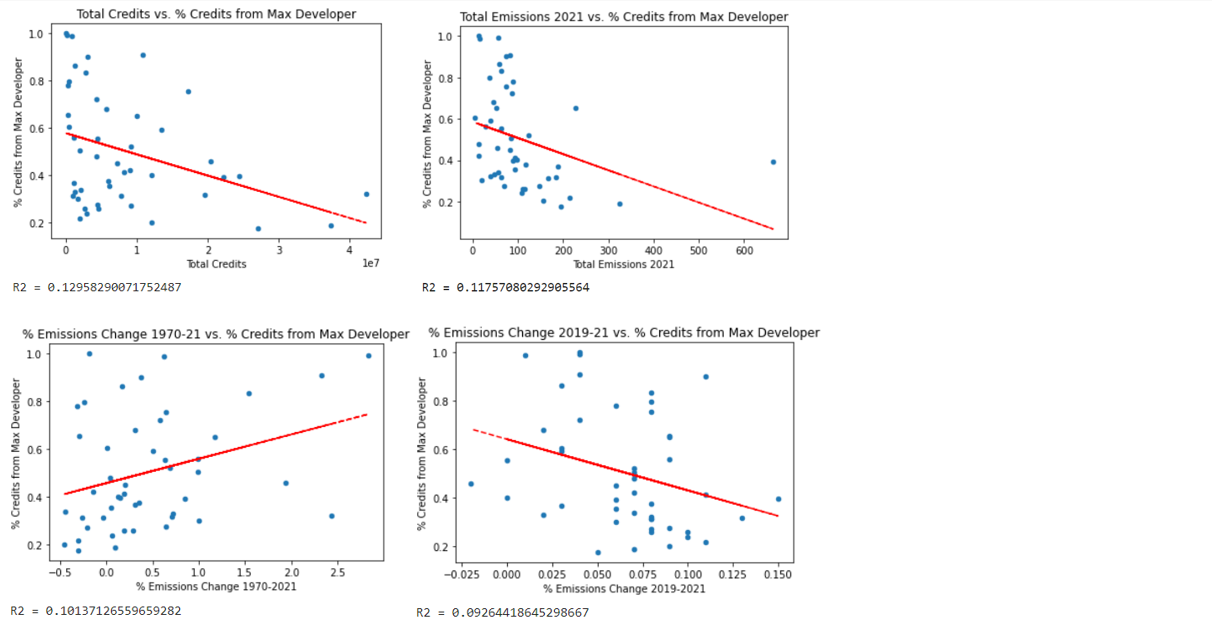

*Are states that heavily create credits more likely to have a dominant developer?

Percent of credits from the largest developer correlated moderately weakly and negatively (r2=0.130) with total credits (upper left). **Higher total credits predict a lower percentage of credits from the dominant developer**, supporting the earlier proposal that developers are more likley to dominate in states with few projects.

*Are states wth larger recent or historic emissions changes more likely to have a dominant developer?*

Percent of credits from the largest developer correlated moderately weakly and positively (r2=0.101) with percent change in emissions from 1970 to 2021 (lower left), moderately weakly and negatively (r2=0.093) with percent change in emissions from 2019 to 2021 (lower right), and moderately weakly and negatively (r2=0.118) with total emissions though that trend is again somewhat driven by the largest emission state (upper right). **High historic emissions change preditcted high percentage of credits from max developer while high recent emissions changes predicted low percentage of credits from max developer**, following patterns of emissions vs. project type dominance, possibly also due to historic emissions change and project dominance both occuring more in western states with large wildnerness-based projects, and recent emissions change's being more common in eastern states with smaller industry-based projects. **Higher total emissions weakly predicts lower percentage of credits from the dominant developer** similar to trends in total emissions vs project type dominance and is likely also from high emissions in the Corn Belt where project types tend to be varied and Texas having the most emissions by far and high project type diversity. **The main difference between project type dominance and developer dominance is that total credits do negatively drive developer dominance but do not drive project type dominance.** 

###  Pie Chart of States' Max Developer

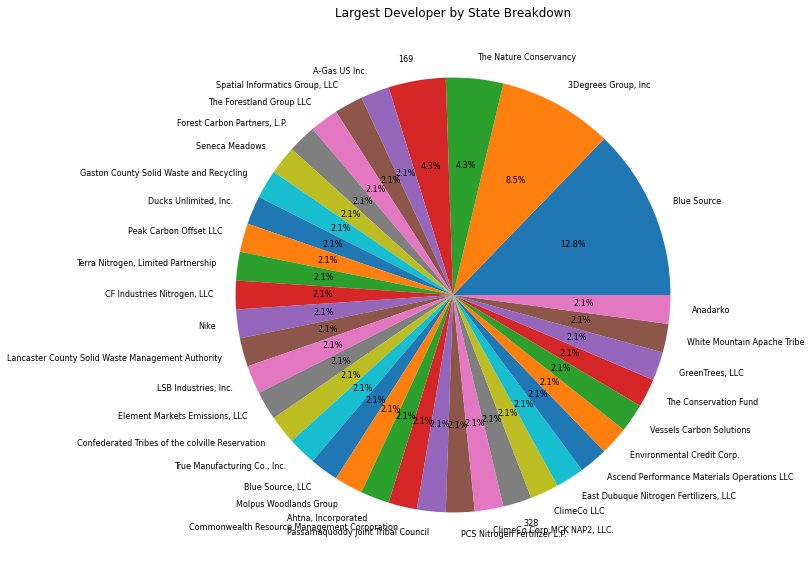

In [19]:
merged_credits_table_4['Project Developer'].value_counts().plot.pie( ylabel='', title = 'Largest Developer by State Breakdown',
                                                                    fontsize= 8, autopct ='%1.1f%%', figsize=(10, 10), labeldistance=1.1);

*Are there any developers that are often the largest in multiple states?*

**Blue Source as the most common largest developer in states at 12.8%, followed by 3 Degrees Group Inc. at 8.5% and The Nature Conservancy and 169 both at 4.3%.** 

In [ ]:
###  Table of Max Developers Country-Wide

In [209]:
total_credits_dev_largest

,Project Developer,Total_Credits,Percent
0,169,7927044.0,0.019082
15,"3Degrees Group, Inc",7060605.0,0.016996
21,A-Gas US Inc.,6173995.0,0.014862
32,"Ahtna, Incorporated",13618537.0,0.032783
37,Anadarko,9423482.0,0.022684
43,Ascend Performance Materials Operations LLC,6492667.0,0.015629
61,Blue Source,35966001.0,0.086578
62,"Blue Source, LLC",6181510.0,0.014880
108,ClimeCo LLC,4257719.0,0.010249
115,Confederated Tribes of the colville Reservation,13022165.0,0.031347


*Do any developers dominate carbon credits country-wide?*

**Blue Source is the developer with the most carbon credits at 8.7%, followed by Forest Carbon Partners, Ahtna, Sealaska, and Confederated Tribes of the colville Reservation.** There are 360 unique developers and percentages of become very small for most of them.

### Table of Sustainable Agriculture Projects by State

In [210]:
project_credits_s_a_3

,State,Type,Total_Project_Credits,Total_Credits_Sum,percent_SA
0,ARKANSAS,Sustainable Agriculture,32.0,19594818.0,0.000002
1,MASSACHUSETTS,Sustainable Agriculture,111645.0,2094281.0,0.053309
2,MINNESOTA,Sustainable Agriculture,0.0,7233099.0,0.000000


*What percentage of credits do Sustainable Agriculture projects make up?*

**Sustainable Agriculture projects make up .053311% of voluntary carbon credits nation-wide.**

*Which states have the most credits from Sustainable Agriculture?* 

**Almost all of these come from Massachusetts and a few come from Arkasas.** Minnesota is in the process of aquiring some but currently has none. No other states are in the process of aquiring any. **Overall Sustainable Agriculutre accounts for little of the voluntary carbon credit market compared to other project types.** 

### Table of All Sustainable Agriculture Projects with Developers

In [211]:
credits_s_a_dev

,Project Name,Type,Project Developer,Total_Project_Credits
94,AgriCapture Soil Enrichment #1,Sustainable Agriculture,AgriCapture Inc,32.0
145,Arva Carbon Ready USA,Sustainable Agriculture,Arva Intelligence,0.0
271,CIBO Initiative for Scaling Regenerative Agric...,Sustainable Agriculture,CIBO Technologies,0.0
303,Charting a New Course - Carbon Insetting Program,Sustainable Agriculture,Bayer,0.0
756,Indigo U.S. Project No.1,Sustainable Agriculture,Indigo Ag,111645.0
1237,Truterra Carbon Program,Sustainable Agriculture,Truterra LLC,0.0


*Which project developers are most involved with Sustainable Agriculture projects?*

**Indigo Ag is the largest Sustainable Agriculture developer due to Indigo U.S. Project No. 1. AgriCapture Inc is the next largest Sustainable Agriculture developer due to the AgriCapture Soil Enrichment Number 1 project. Arva Intelligence, CIBO Technologies, Bayer, and Truterra LLC are all involved with Sustainable Agriculture carbon credit projects that have not yeilded credits.** Though, all developers in this table with zero credits but Truterra LLC dissapear when grouped by state because the project is not linked to a specific state. Most of the 0 credit projects are undergoing verification. 

## Conclusions and Recomendations: 

The West Coast tends to produce the most voluntary carbon credits and the Great Plains region produces the least, though high and low producing states are overall fairly dispersed. Texas has the largest carbon emisssions followed by Califonia, Florida, and then the Rust Belt. Carbon credit production does not correlate strongly with emissions data. High carbon credit production on the West Coast may be driven by the oppurtunity vast wildnerness provides, while high emissions in some southern states and the Rust Belt may be driven by a combination of industy and population factors. The largest historic emissions increases occur in the West, possibly due to population shifts as the Northwest and coasts' increase in residency popularity, while the largest recent emissions increase in the Southeast, possibly due to growing cities in the regions, increased energy production, or policty changes. Total credit creation correlated weakly with historic emissions changes, though this could be due to larger size and population leading independently to both. Total credit creation also correlated weakly with recent emissions changes. Incorporating population data into further analysis could determine if population changes are driving emission changes and how population may relate to carbon credit creation. 

Western states tended to have a larger portion of carbon credits come from a single project type, which could be due to the amount of wilderness available for carbon projects. These states usually had Improved Forest Management or Avoided Grassland and Forest Conversion as their largest project type, while smaller eastern states often had production-related largest project types. Total credits did not correlate with project type dominance, but historic change in emissions correlated positively and recent change in emissions correlated weakly negatively. These patterns could be occuring because large historic emissions changes and project dominance are both more likely to occur in western states with large wildnerness-based projects while large recent emission changes are likely to occur in eastern states with smaller, industry-based projects. Total emissions correlated negatively with project type dominance possibly from high emissions in the Corn Belt where projects type tends to be varied and Texas' combination of highest emissions and high project type diversity. Improved Forest Management and Landfill Methane were the projects most likely to dominate states credits and Forest Management dominated nationwide by a large margin. This might be because Imporved Forest Management is an efficient carbon carbon credit producer and therefore popular, or because the nature of Improved Forest Management and Landfill Methane lend themselves to large-scale projects. 

Western states were also more likely than eastern states to create most of their credits via a single developer, though the pattern is likely due to smaller states with carbon credits in general being more likley to be dominated by a single developer, unlike the pattern with project type. This can be seen in the differences between the total credits vs. project type dominance and total credits vs. developer dominance scatterplots. The scatterplots for emission changes and total emissions vs. dominance, however, resemble the project type patterns and are likely being driven by the same factors. Blue Source, 3 Degrees Group Inc. and The Nature Conservancy were the only developers that dominated in multiple states. Out of the 360 developers, Blue Source has the most carbon credits nation-wide at around eight percent followed by Forest Carbon Partners, Ahtna, Sealaska, and Confederated Tribes of the colville Reservation at around three percent each. 

Sustainable Agriculture projects make up very little of the voluntary carbon credit market at 0.053311%. Almost all Sustainable Agriculture credits come from Massachusetts and a few from Arkansas. Indigo Ag is the largest Sustainable Agriculture developer, followed by Agricapture Inc. Four other projects are in development but have yet to yeild credits. 

<div> <img src="copytest.png" alt="Drawing" style="width: 00px;"/></div> 